# Generating dataset for Ballymun noise data, traffic and weather from January to June 2019

In order to generate a training data set for the prediction of Ballymun noise monitor data traffic volume data was downloaded from TII traffic data: https://trafficdata.tii.ie/publicmultinodemap.asp for the Ballymun monitor (ID: TMU R108 000.0 N) 

A dataset was generated made up of noise monitor value data (LAeq), hourly weather data and hourly traffic volume data between January and June 2019.

Elements of this dataset were then used to generate different supervised regression models.

In [1]:
# import libraries

import pandas as pd
import numpy as np

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# set random seed for reproducibility
SEED = 1 # 

In [2]:
# Set the start and end dates for the range of time - want to look at noise, traffic and weather between jan-june 2019

start_date = pd.Timestamp('2019-01-01')
end_date = pd.Timestamp('2019-06-23 23:00:00')

# Generate a list of hourly datetime objects for the specified period
hourly_range = pd.date_range(start=start_date, end=end_date, freq='H')

# Convert the datetime objects to the desired string format
hourly_range_formatted = hourly_range.strftime('%Y-%m-%d %H:%M:%S')


In [3]:
# read in the traffic volume data for Ballymun 

df = pd.read_csv('../Data/datasets/ballymun_traffic.csv') # load in the traffic data for Ballymun between 1st Jan and 23rd June 2019

# get rid of unnamed columns, might have originated from the file in excel format

columns_drop = ['Unnamed: 175', 'Unnamed: 176',
       'Unnamed: 177', 'Unnamed: 178', 'Unnamed: 179', 'Unnamed: 180',
       'Unnamed: 181']
for col in columns_drop:
    df.drop(col, axis=1, inplace=True)
    
cols = df.columns.drop('Time') # select all columns to be melted together instead of a row of columns want them in one column. Want everything melted except for time.

#melt the columns together

melted = pd.melt(df, id_vars=['Time'], value_vars=cols)

# add in the range of datetime values that were generated above to have a new datetime column

melted['datetime'] = hourly_range_formatted 

df_ballymun_traffic = melted[['datetime', 'value']] # create new df containing Ballymun traffic

In [4]:
# import Ballymun data and choose the same range in 2019

df_ballymun_noise = pd.read_csv('../Data/csv_files_mergedJson_requests/2015_2021Ballymun4.csv', parse_dates=['datetime'], sep = '\t')

# just interested in these two columns the 'datetime' and the LAeq noise values
df_ballymun_noise2 = df_ballymun_noise[['datetime', 'laeq_Ballymun4']]

# set index to datetime
df_ballymun_noise2.set_index('datetime', inplace=True)

# use datetime range desired with .loc to make a subset of the ballymun LAeq data
ballymun_noise_tomerge = df_ballymun_noise2.loc['2019-01-01': '2019-06-23']

In [5]:
# change traffic data 'datetime' to type datetime

df_ballymun_traffic['datetime'] = pd.to_datetime(df_ballymun_traffic['datetime'])

# merge traffic and LAeq data for Ballymun

df_merged = pd.merge(ballymun_noise_tomerge, df_ballymun_traffic, on='datetime', how='right')

/var/folders/3w/qk3jn0b95mb0c72rjz15z8340000gn/T/ipykernel_3958/4294097975.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ballymun_traffic['datetime'] = pd.to_datetime(df_ballymun_traffic['datetime'])


In [6]:
# clean up the merged dataframe by dropping NAs and changing traffic volume to float

df_merged.dropna(inplace=True)

df_merged['value'] = df_merged['value'].astype(float)

In [7]:
# import weather dataset to merge

weather = pd.read_csv('../Data/datasets/2015to2021_weather.csv', sep='\t', parse_dates = ['datetime'])

weather.set_index('datetime', inplace=True)

weather_to_merge = weather.loc['2019-01-01': '2019-06-23']

df_traffic_weather_noise = pd.merge(df_merged, weather_to_merge, on='datetime', how='right')

# add in 'hour' column which is the hour of the day in 24h clock and day of the week
df_traffic_weather_noise['hour'] = df_traffic_weather_noise['datetime'].dt.hour
df_traffic_weather_noise['day_of_week'] = df_traffic_weather_noise['datetime'].dt.dayofweek


# rename 'value' column as 'traffic_volume' and 'rain' as 'rainfall' for clarity
df_traffic_weather_noise.rename(columns= {'laeq_Ballymun4': 'noise', 'value': 'traffic_volume', 'rain': 'rainfallmm'}, inplace=True)

In [8]:
# inspect correlation coefficient matrix for variables that might be good predictors for LAeq Ballymun values

df_traffic_weather_noise.corr()

,noise,traffic_volume,rainfallmm,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ww,w,sun,vis,clht,clamt,hour,day_of_week
noise,1.000000,0.742038,0.111308,0.154165,0.105523,0.026462,0.034780,-0.248482,-0.082418,0.186928,-0.089377,0.097684,0.135862,0.223728,0.066493,-0.097785,0.089105,5.763415e-01,-8.666494e-03
traffic_volume,0.742038,1.000000,0.021899,0.318299,0.240766,0.109986,0.109515,-0.404063,-0.007166,0.195883,-0.052439,0.042464,0.068359,0.381464,0.178786,-0.113345,0.092454,3.656357e-01,-1.142348e-01
rainfallmm,0.111308,0.021899,1.000000,-0.012256,0.038617,0.100208,0.102788,0.198647,-0.248517,0.075159,-0.097681,0.423015,0.322285,-0.094324,-0.244108,-0.133260,0.173198,6.370920e-02,2.493394e-02
temp,0.154165,0.318299,-0.012256,1.000000,0.969520,0.832203,0.818447,-0.441734,0.083820,0.047337,-0.134888,0.015908,0.055279,0.280969,0.212422,-0.247579,0.251749,1.801700e-01,5.428765e-02
wetb,0.105523,0.240766,0.038617,0.969520,1.000000,0.941506,0.928536,-0.213756,0.027493,0.002976,-0.133149,0.097582,0.125410,0.169042,0.091368,-0.294446,0.310451,1.361598e-01,4.924687e-02
dewpt,0.026462,0.109986,0.100208,0.832203,0.941506,1.000000,0.988675,0.123927,-0.053073,-0.068659,-0.112911,0.193828,0.202663,0.003606,-0.081154,-0.321499,0.350091,6.043891e-02,3.153974e-02
vappr,0.034780,0.109515,0.102788,0.818447,0.928536,0.988675,1.000000,0.130317,-0.063457,-0.065799,-0.108996,0.192208,0.202725,0.001019,-0.073886,-0.303184,0.328677,6.048494e-02,4.195319e-02
rhum,-0.248482,-0.404063,0.198647,-0.441734,-0.213756,0.123927,0.130317,1.000000,-0.239899,-0.217564,0.052276,0.296829,0.232216,-0.481769,-0.530281,-0.065338,0.108732,-2.366233e-01,-4.863637e-02
msl,-0.082418,-0.007166,-0.248517,0.083820,0.027493,-0.053073,-0.063457,-0.239899,1.000000,-0.298317,-0.032619,-0.360675,-0.400761,0.118952,0.206883,0.143499,-0.148313,-1.622423e-02,4.846913e-02
wdsp,0.186928,0.195883,0.075159,0.047337,0.002976,-0.068659,-0.065799,-0.217564,-0.298317,1.000000,0.188320,0.177201,0.259624,0.113841,-0.018916,-0.112015,0.080663,3.420094e-02,5.221885e-02


<AxesSubplot:>

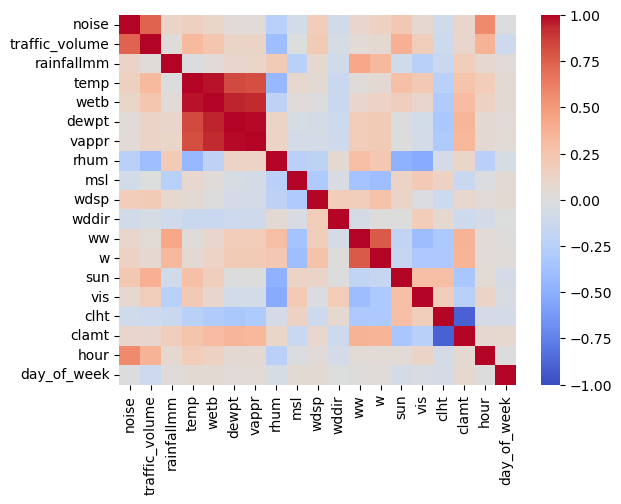

In [9]:
# plot this correlation coefficient matrix using a heatmap for easier visualization

sns.heatmap(df_traffic_weather_noise.corr(), vmin=-1,
            cmap='coolwarm')

# Supervised Machine Learning

In [10]:
# import libraries for supervised machine learning including models and packages for metric evaluation


# scaling data
from scipy.cluster.vq import whiten
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

# tuning models and ensemble
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor



# evaluation and tuning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold



In [11]:
# create dataset to use for the training and prediction - will use traffic volume, rainfall and time of day to predict noise

df_learning = df_traffic_weather_noise[['noise', 'traffic_volume', 'rainfallmm', 'hour']].dropna()

# Create X and y arrays for the predictors (X) and the predicted variable (y)

X = df_learning.drop("noise", axis=1)
y = df_learning["noise"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [12]:
# generate a linear regression model 

# Instantiate the model
reg = LinearRegression()

# Fit the model to the data
reg.fit(X_train, y_train)

# Make predictions
y_pred_linear = reg.predict(X_test)

# Compute R-squared
r_squared_linear = reg.score(X_test, y_test)

# Compute RMSE
rmse_linear = mean_squared_error(y_test, y_pred_linear, squared=False) #If squared True returns MSE value, if False returns RMSE value.

# Create a KFold object for cross validation of this model

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

# Compute 6-fold cross-validation scores
cv_scores_R2_linear = cross_val_score(reg, X, y, cv=kf)
cv_scores_NegMSE_linear = cross_val_score(reg, X, y, cv=kf, scoring = 'neg_mean_squared_error')


# Print scores
print(f'The mean R-squared value for linear regression model is: {np.mean(cv_scores_R2_linear)}')
print(f' The mean Root Mean Squared Error is: {np.mean(np.sqrt(np.abs(cv_scores_NegMSE_linear)))}')

The mean R-squared value for linear regression model is: 0.6619283158519493
 The mean Root Mean Squared Error is: 2.253819700910088


In [13]:
# generate a ridge regression model and tune the alpha hyperparameter

scores_ridge = []
rmse_ridge = []
for alpha in [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    scores_ridge.append(ridge.score(X_test, y_test))
    rmse_ridge.append(mean_squared_error(y_test, y_pred_ridge, squared=False))

#print("RMSE: {}".format(rmse_ridge))
#print("scores: {}".format(scores_ridge))

# alpha 100 has the lowest RMSE and the highest score for ridge regression in this case so will use this for kfold cross validation

# Instantiate the model
ridge = Ridge(alpha = 100.0)

# Fit the model to the data
ridge.fit(X_train, y_train)

# Make predictions
y_pred_ridge = ridge.predict(X_test)

# Compute R-squared
r_squared_ridge = ridge.score(X_test, y_test)

# Compute RMSE
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False) #If squared True returns MSE value, if False returns RMSE value.

# Create a KFold object for cross validation of this model

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

# Compute 6-fold cross-validation scores
cv_scores_R2_ridge = cross_val_score(ridge, X, y, cv=kf)
cv_scores_NegMSE_ridge = cross_val_score(ridge, X, y, cv=kf, scoring = 'neg_mean_squared_error')


# Print scores
print(f'The mean R-squared value for ridge regression model is: {np.mean(cv_scores_R2_ridge)}')
print(f' The mean Root Mean Squared Error for ridge regression model is: {np.mean(np.sqrt(np.abs(cv_scores_NegMSE_ridge)))}')

The mean R-squared value for ridge regression model is: 0.6618670339661834
 The mean Root Mean Squared Error for ridge regression model is: 2.254030210079647


In [14]:
# generate a lasso regression model and tune the alpha hyperparameter

# using Lasso regression and changing alpha
scores_lasso = []
rmse_lasso = []

for alpha in [0.001, 0.01, 1.0, 10.0, 20.0, 50.0]:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    lasso_pred = lasso.predict(X_test)
    scores_lasso.append(lasso.score(X_test, y_test))
    rmse_lasso.append(mean_squared_error(y_test, lasso_pred, squared=False))

#print("RMSE: {}".format(rmse_lasso))
#print(scores_lasso)

# alpha of 0.01 gives lowest RMSE and highest R-squared

# Instantiate the model
lasso = Lasso(alpha = 0.01)

# Fit the model to the data
lasso.fit(X_train, y_train)

# Make predictions
y_pred_lasso = lasso.predict(X_test)

# Compute R-squared
r_squared_lasso = lasso.score(X_test, y_test)

# Compute RMSE
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False) #If squared True returns MSE value, if False returns RMSE value.

# Create a KFold object for cross validation of this model

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

# Compute 6-fold cross-validation scores
cv_scores_R2_lasso = cross_val_score(lasso, X, y, cv=kf)
cv_scores_NegMSE_lasso = cross_val_score(lasso, X, y, cv=kf, scoring = 'neg_mean_squared_error')


# Print scores
print(f'The mean R-squared value for ridge regression model is: {np.mean(cv_scores_R2_lasso)}')
print(f' The mean Root Mean Squared Error for ridge regression model is: {np.mean(np.sqrt(np.abs(cv_scores_NegMSE_lasso)))}')

The mean R-squared value for ridge regression model is: 0.6618962192442567
 The mean Root Mean Squared Error for ridge regression model is: 2.2539270078444056


In [15]:
# Generate a decision tree regressor and see which max_depth parameter initially gives best metrics

# max_depth for tree
max_d = [2, 3, 4, 5, 6, 7]

scores_tree = []
rmse_tree = []


# Instantiate the model and loop through parameter
for param in max_d:
    dt = DecisionTreeRegressor(max_depth=param)
    dt.fit(X_train, y_train)  
    y_pred_tree = dt.predict(X_test) 
    scores_tree.append(lasso.score(X_test, y_test))
    rmse_tree.append(mean_squared_error(y_test, y_pred_tree, squared=False))

#print("RMSE: {}".format(rmse_tree))
#print(scores_tree)

# lowest RMSE and highest score has max_depth = 6 so do kfold cross validation for this model

regressor = DecisionTreeRegressor(max_depth=6) 

regressor.fit(X_train, y_train) 

y_pred_regressor = regressor.predict(X_test)  # X_test is your feature data for prediction

# Create a KFold object for cross validation of this model

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

# Compute 6-fold cross-validation scores
cv_scores_R2_regressor = cross_val_score(regressor, X, y, cv=kf)
cv_scores_NegMSE_regressor = cross_val_score(regressor, X, y, cv=kf, scoring = 'neg_mean_squared_error')


# Print scores
print(f'The mean R-squared value for decision tree regression model is: {np.mean(cv_scores_R2_regressor)}')
print(f' The mean Root Mean Squared Error for decision tree regression model is: {np.mean(np.sqrt(np.abs(cv_scores_NegMSE_regressor)))}')



The mean R-squared value for decision tree regression model is: 0.743537584781437
 The mean Root Mean Squared Error for decision tree regression model is: 1.963858536398271


In [16]:
# Decision tree regressor gives best metrics so far, will try reduce variance with bagging and random forest regressor and boosting with gradient boosting and stochastic gradient boosting see if can be improved

# first try bagging regressor

# try this with bagging so bootstrap samples are used to train multiple models and then its aggregated see if it reduces variance - this looks way better!

# Instantiate the model
dt = DecisionTreeRegressor(max_depth=6)

# Create a bagging regressor with the linear regression model as the base estimator
bag_dt = BaggingRegressor(base_estimator=dt, n_estimators=100, random_state=42)

# Fit the bagging regressor to the training data
bag_dt.fit(X_train, y_train)

# Make predictions
y_pred_dt_bag = bag_dt.predict(X_test)

# Create a KFold object for cross validation of this model

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

# Compute 6-fold cross-validation scores
cv_scores_R2_tree_bag = cross_val_score(bag_dt, X, y, cv=kf)
cv_scores_NegMSE_tree_bag = cross_val_score(bag_dt, X, y, cv=kf, scoring = 'neg_mean_squared_error')


# Print scores
print(f'The mean R-squared value is: {np.mean(cv_scores_R2_tree_bag)}')
print(f' The mean Root Mean Squared Error is: {np.mean(np.sqrt(np.abs(cv_scores_NegMSE_tree_bag)))}')

The mean R-squared value is: 0.7692441620838093
 The mean Root Mean Squared Error is: 1.8611444934429475


In [17]:
# try using random forest of regression trees bagging


# instantiate random forest regressor with 400 estimators
rf = RandomForestRegressor(n_estimators=300, min_samples_leaf=0.1, random_state=1)

# fit 'rf' to the training set
rf.fit(X_train, y_train)

# predict the test set labels 'y_pred'
y_pred_rf = rf.predict(X_test)

# Create a KFold object for cross validation of this model

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

# Compute 6-fold cross-validation scores
cv_scores_R2_rf = cross_val_score(rf, X, y, cv=kf)
cv_scores_NegMSE_rf = cross_val_score(rf, X, y, cv=kf, scoring = 'neg_mean_squared_error')


# Print scores
print(f'The mean R-squared value is: {np.mean(cv_scores_R2_rf)}')
print(f' The mean Root Mean Squared Error is: {np.mean(np.sqrt(np.abs(cv_scores_NegMSE_rf)))}')

The mean R-squared value is: 0.6699219508186569
 The mean Root Mean Squared Error is: 2.2271051096538907


In [18]:
# try a gradient booster regressor model

# instantiate a GradientBoostingRegressor 'gbt'
gbt = GradientBoostingRegressor(n_estimators=300, max_depth = 2, random_state=SEED)

# fit gbt to training set
gbt.fit(X_train, y_train)

# predict the test set labels
y_pred_gbt = gbt.predict(X_test)

# Create a KFold object for cross validation of this model

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

# Compute 6-fold cross-validation scores
cv_scores_R2_gbt = cross_val_score(gbt, X, y, cv=kf)
cv_scores_NegMSE_gbt = cross_val_score(gbt, X, y, cv=kf, scoring = 'neg_mean_squared_error')


# Print scores
print(f'The mean R-squared value is: {np.mean(cv_scores_R2_gbt)}')
print(f' The mean Root Mean Squared Error is: {np.mean(np.sqrt(np.abs(cv_scores_NegMSE_gbt)))}')

The mean R-squared value is: 0.766955069786369
 The mean Root Mean Squared Error is: 1.8717366556462678


In [19]:
# try a stochastic gradient boosting regressor model


sgbt = GradientBoostingRegressor(max_depth=2, subsample = 0.8, max_features = 0.2, n_estimators = 300, random_state=SEED)

sgbt.fit(X_train, y_train)

y_pred_sgbt = sgbt.predict(X_test)

# Create a KFold object for cross validation of this model

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

# Compute 6-fold cross-validation scores
cv_scores_R2_sgbt = cross_val_score(sgbt, X, y, cv=kf)
cv_scores_NegMSE_sgbt = cross_val_score(sgbt, X, y, cv=kf, scoring = 'neg_mean_squared_error')


# Print scores
print(f'The mean R-squared value is: {np.mean(cv_scores_R2_sgbt)}')
print(f' The mean Root Mean Squared Error is: {np.mean(np.sqrt(np.abs(cv_scores_NegMSE_sgbt)))}')

The mean R-squared value is: 0.7724763834921088
 The mean Root Mean Squared Error is: 1.8485620409498629


# Summarizing the performance

In [20]:
# Make a dataframe comparing some of the different metrics
# r-squared for how much variation can be explained by the model and RMSE for how much difference is in the predicted values from the training data

models = ['Linear regression', 'Ridge regression', 'Lasso regression', 'Decision tree regressor', 'Bagging regressor tree', 'Random forest regressor', 'Gradient boosted tree', 'Stochastic gradient boosted tree' ]
R_squared = [cv_scores_R2_linear, cv_scores_R2_ridge, cv_scores_R2_lasso, cv_scores_R2_regressor, cv_scores_R2_tree_bag, cv_scores_R2_rf, cv_scores_R2_gbt, cv_scores_R2_sgbt]

# generate root mean squared error list
neg_SME = [cv_scores_NegMSE_linear, cv_scores_NegMSE_ridge, cv_scores_NegMSE_lasso, cv_scores_NegMSE_regressor, cv_scores_NegMSE_tree_bag, cv_scores_NegMSE_rf, cv_scores_NegMSE_gbt, cv_scores_NegMSE_sgbt ]
SME = list(map(np.abs, neg_SME ))
RMSE_list = list(map(np.sqrt, SME))
mean_error = list(map(np.mean, RMSE_list))

# generate dictionary for dataframe
# apply numpy.mean function to the array of cross-validated metrics to get the mean R**2 and RMSE for each model
metric_dictionary = {'Model': models, 'R-squared': list(map(np.mean, R_squared)), 'RMSE': mean_error }

In [21]:
performance_df = pd.DataFrame(metric_dictionary)

# sort by lowest variation explained to the highest
performance_df.sort_values(by='R-squared', inplace=True)

performance_df.style.hide_index()



/var/folders/3w/qk3jn0b95mb0c72rjz15z8340000gn/T/ipykernel_3958/2456184405.py:6: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  performance_df.style.hide_index()


Model,R-squared,RMSE
Ridge regression,0.661867,2.254030
Lasso regression,0.661896,2.253927
Linear regression,0.661928,2.253820
Random forest regressor,0.669922,2.227105
Decision tree regressor,0.743538,1.963859
Gradient boosted tree,0.766955,1.871737
Bagging regressor tree,0.769244,1.861144
Stochastic gradient boosted tree,0.772476,1.848562


# Plot the difference between prediction error in models

In order to visualize the difference between the worst performing model generated (Ridge regression model) and the best (stochastic gradient boosted regressor tree) can plot the difference in the residual errors from the model predictions minus the training data.

Text(0.5, 1.0, 'Prediction Residual Error for Noise using Different Models')

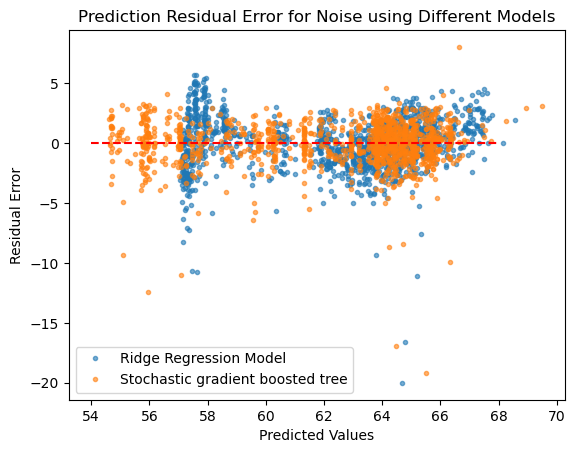

In [22]:
plt.plot(y_pred_ridge, y_pred_ridge - y_test, marker = '.', linestyle = 'none', label = 'Ridge Regression Model',alpha=0.6)
plt.plot(y_pred_sgbt, y_pred_sgbt - y_test, marker = '.', linestyle = 'none', label = 'Stochastic gradient boosted tree',alpha=0.6)

plt.legend()

# add a line where y = 0, where the error for prediction is 0
line_point1 = [54,0]
line_point2 = [68, 0]
x_line = [line_point1[0], line_point2[0]]
y_line = [line_point1[1], line_point2[1]]
plt.plot(x_line, y_line, color = 'red', linestyle = 'dashed')

plt.xlabel('Predicted Values')
plt.ylabel('Residual Error')
plt.title('Prediction Residual Error for Noise using Different Models')